# Network_Montpellier

Network_Montpellier is a python package that able to produce videos and widget representing a car, a pedestrian and a bicycle going from la maison du Lez to Place Eugène Bataillon in Montpellier with the shortest path possible.

Below we present the points that we will follow for the report :
* load the necessary packages,
* print the shortest path between La Maison du Lez to Place Eugène Bataillon according to the type of transport,
* widget depending on the type of transport,
* animation which draw shortest path between La Maison du Lez to Place Eugène Bataillon according to the type of transport,
* calculate the distance between La Maison du Lez to Place Eugène Bataillon according to the type of transport,
* time study

## Loading packages

First, we start by loading the necessary packages

In [1]:
import sys
import os
import time
import folium
import networkx as nx
import osmnx as ox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from folium import plugins
from ipywidgets import interact
from IPython.display import clear_output
%matplotlib notebook
ox.config(log_console=True, use_cache=True)


In order to use our functions to plot the shortest path and make animations, we have to import our package.

In [2]:
sys.path.append(os.path.dirname(
    os.path.abspath('network_montpellier')) + (os.path.sep + '..'))
import network_montpellier as net

## Visualization of the shortest path between la Maison du Lez to Place Eugène Bataillon in Montpellier

* By walk

<IPython.core.display.Javascript object>


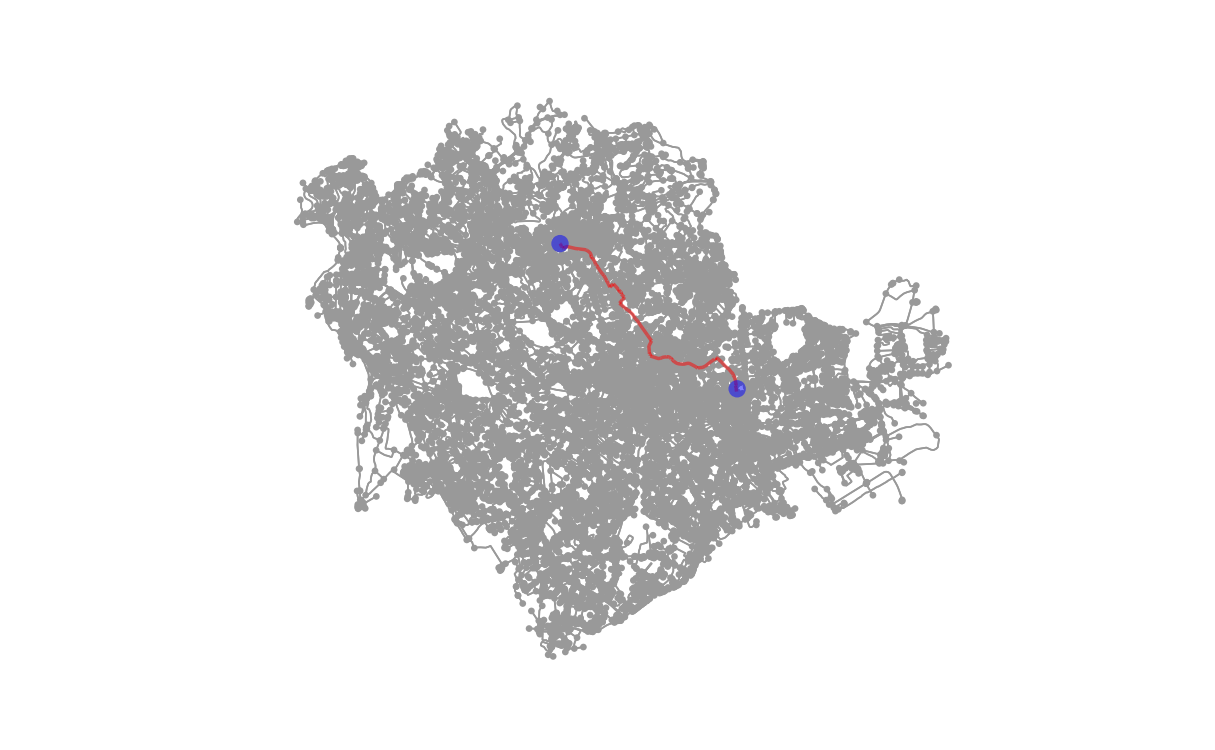

()

In [3]:
net.type_transport('walk')

* By bike

<IPython.core.display.Javascript object>


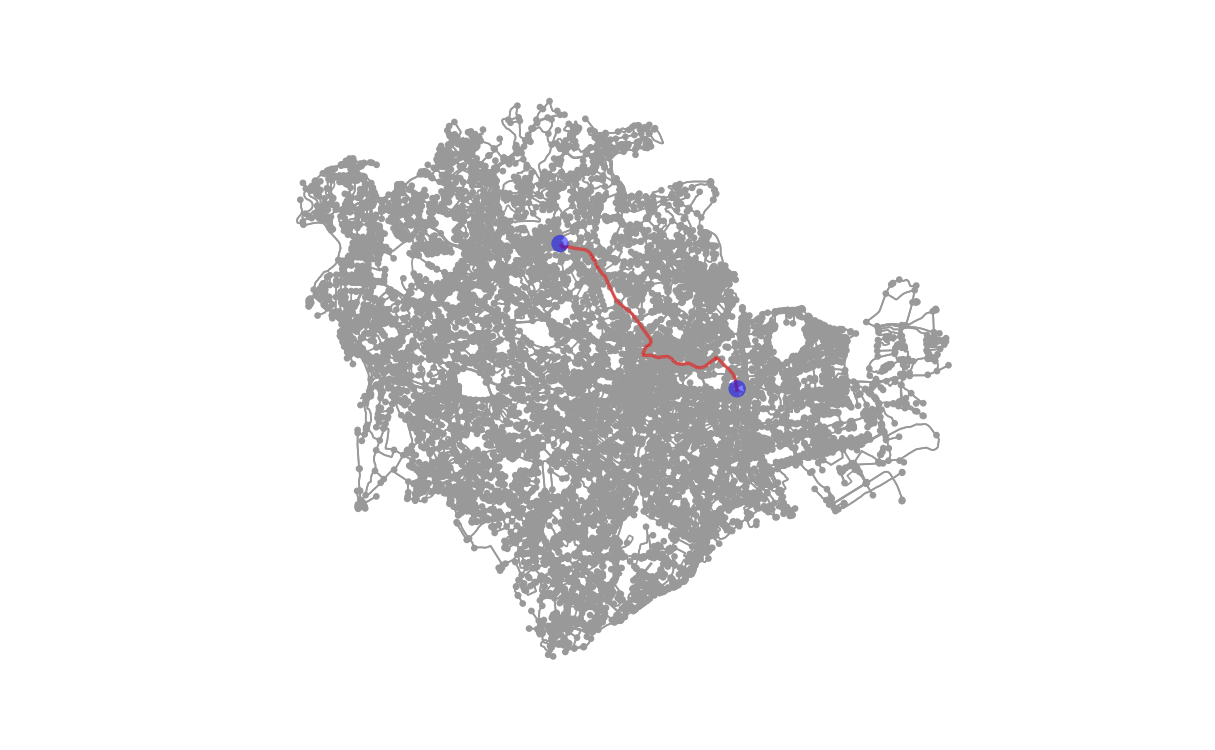

()

In [4]:
net.type_transport('bike')

* By car

<IPython.core.display.Javascript object>


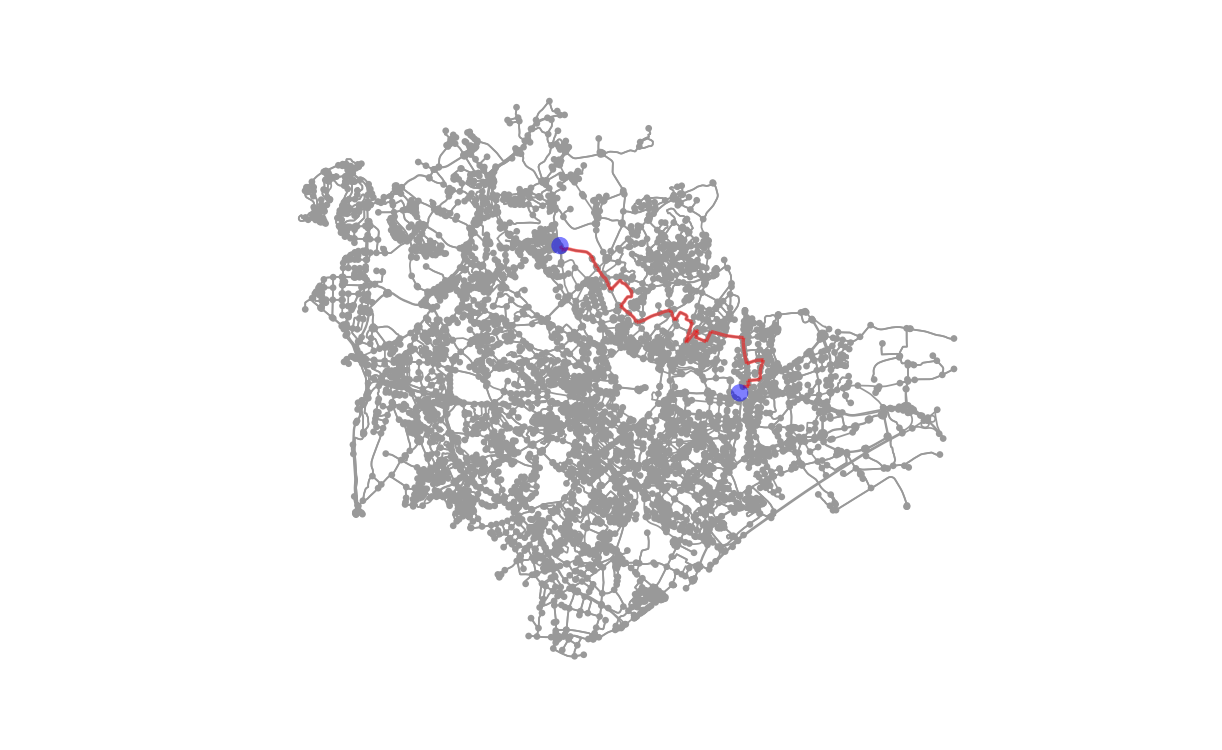

()

In [5]:
net.type_transport('drive')

## Widget for choosing the type of transport

Using this widget, we can select the type of transport we want to use to go from La Maison du Lez to Place Eugène Bataillon.
This will display an osmnx graph and draw the shortest path between these two points.

In [6]:
menu = [('car', 'drive'), ('bike', 'bike'), ('piedestrian', 'walk')]
interact(net.type_transport, transport=menu)

interactive(children=(Dropdown(description='transport', options=(('car', 'drive'), ('bike', 'bike'), ('piedest…

<function network_montpellier.make_map.code.type_transport(transport)>

## Animation of the shortest path according to the type of transport

Below we can see three animations. First, for a person moving on foot. Then, for a person moving by bicycle and finally by car.
This allows you to trace the path as you go, starting from La Maison du Lez and going to Place Eugène Bataillon.

* By walk

<IPython.core.display.Javascript object>


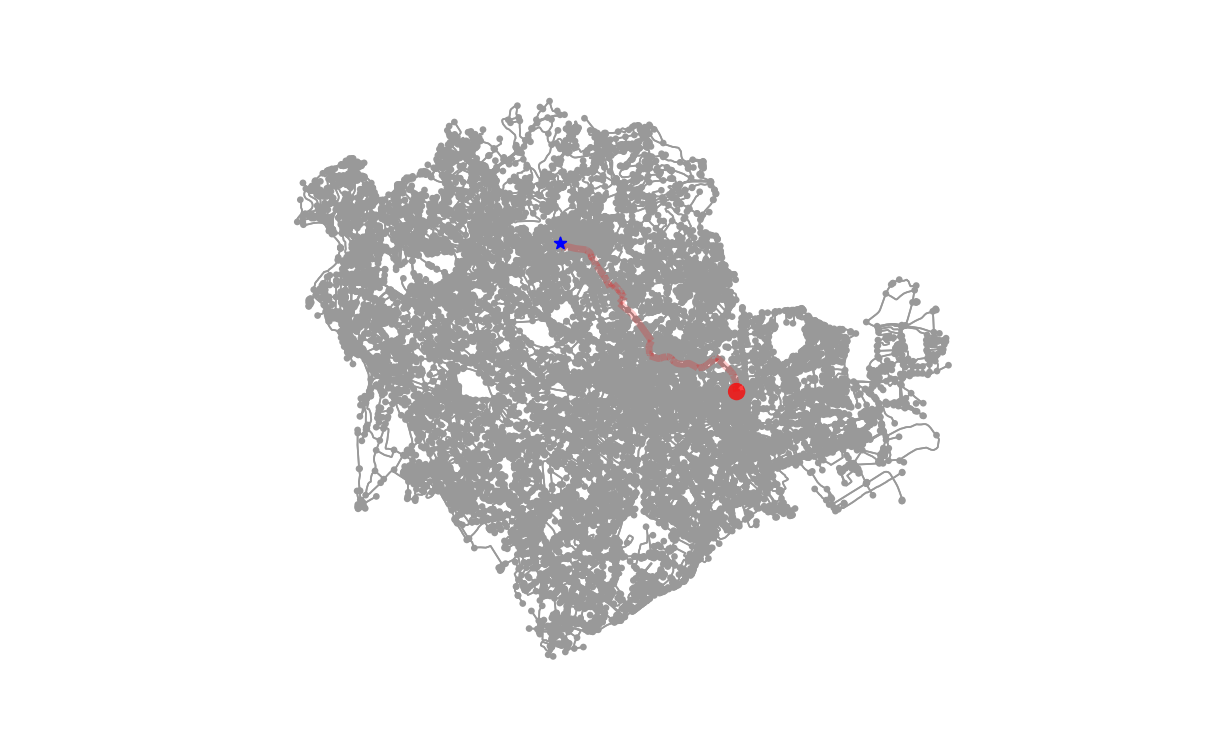

In [7]:
net.animation_type_transport('walk')

* By bike

<IPython.core.display.Javascript object>


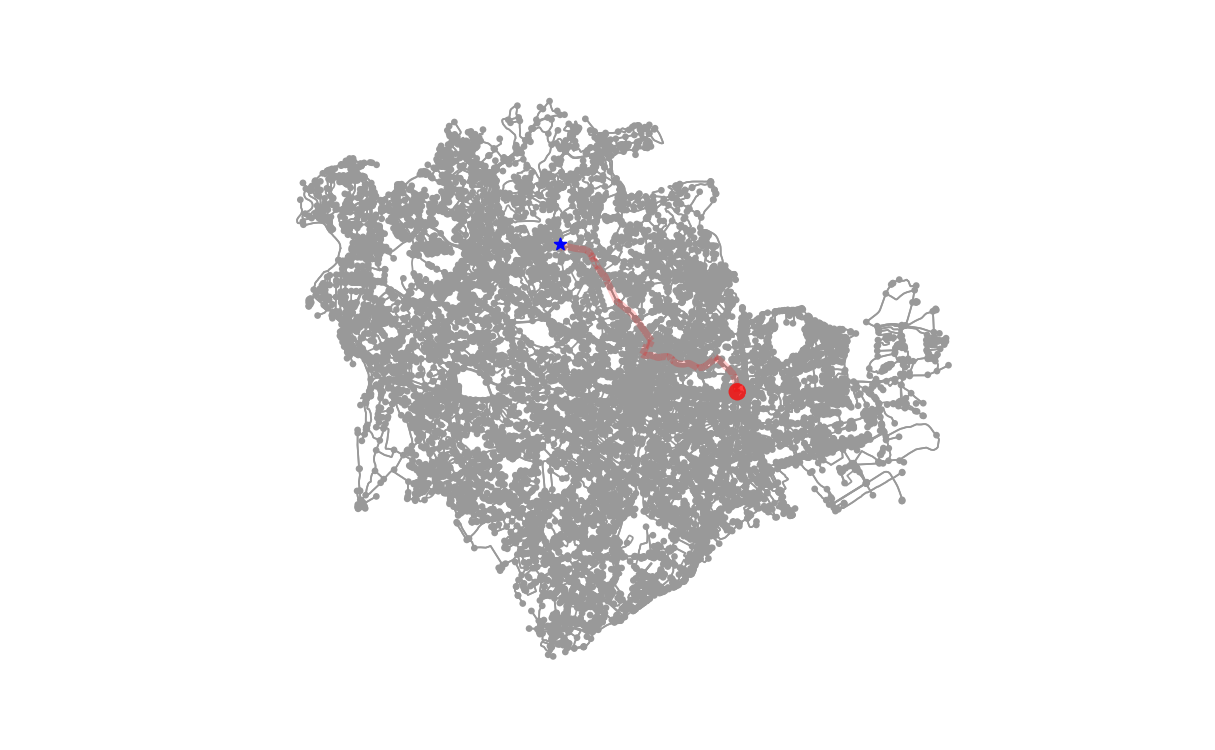

In [8]:
net.animation_type_transport('bike')

* By car

<IPython.core.display.Javascript object>


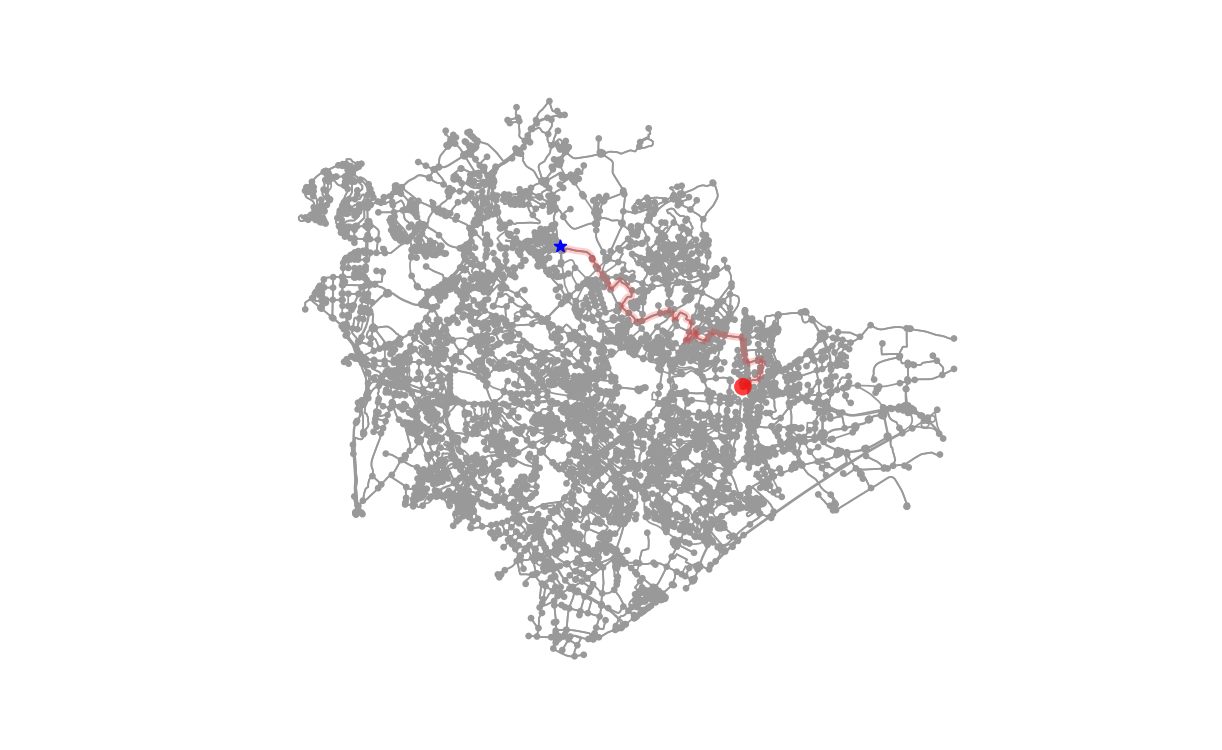

In [9]:
net.animation_type_transport('drive')

## Visualizing shortest path on interactive and animated maps with Folium plugins

We can also animate the shortest path between la Maison du Lez to Place Eugène Bataillon in Montpellier by different mode of transport on an interactive map using the folium plugin "Timestamped GeoJSON".

* By walk

In [10]:
df_walk = net.geojson_data('walk')

In [11]:
# to display the map
net.geojson_visualization(df_walk)

In [12]:
# mode = ["walk", "bike", "drive", "drive_service", "all", "all_private", "none"]
# interact(df, transport = mode)

* By bike

In [13]:
df_bike = net.geojson_data('bike')

In [14]:
# to display the map
net.geojson_visualization(df_bike)

* By car

In [15]:
df_drive = net.geojson_data('drive')

In [16]:
# to display the map
net.geojson_visualization(df_drive)

## Distance in meters according to the type of transport 

We will now calculate the distance in meters between La Maison du Lez and Place Eugène Bataillon according to the type of transport in order to know which path is the longest.

* By bike

In [17]:
print("The cycling distance between La Maison du Lez and Place Eugène Bataillon is " +
      str(np.round(net.distance_type_transport('bike'), 3)) + " meters")

The cycling distance between La Maison du Lez and Place Eugène Bataillon is 4339.374 meters


You can also use the class to display the distance (in meters).

In [18]:
bike = net.network(transport='bike')
bike.distance()

4339.373999999999

* By walk

In [19]:
print("The walking distance between La Maison du Lez and Place Eugène Bataillon is " +
      str(np.round(net.distance_type_transport('walk'), 3)) + " meters")

The walking distance between La Maison du Lez and Place Eugène Bataillon is 4154.62 meters


* By car

In [20]:
print("The driving distance between La Maison du Lez and Place Eugène Bataillon is " +
      str(np.round(net.distance_type_transport('drive'), 3)) + " meters")

The driving distance between La Maison du Lez and Place Eugène Bataillon is 5031.094 meters


In view of the results, we see that the longest path (in terms of distance) is for a person traveling by car. Conversely, the shortest path (in terms of distance) is for a person moving on foot.

## Time study

We will make a study of the time for each function according to the type of transport. 
So, we first store the times in variables then we will make a histogram on these.

* By walk

In [21]:
times_walk_type_transport = net.times('walk', net.type_transport)
clear_output()
times_walk_distance = net.times('walk', net.distance_type_transport)
times_walk_animation = net.times('walk', net.animation_type_transport)
clear_output()

* By bike

In [22]:
times_bike_type_transport = net.times('bike', net.type_transport)
clear_output()
times_bike_distance = net.times('bike', net.distance_type_transport)
times_bike_animation = net.times('bike', net.animation_type_transport)
clear_output()

* By car

In [23]:
times_drive_type_transport = net.times('drive', net.type_transport)
clear_output()
times_drive_distance = net.times('drive', net.distance_type_transport)
times_drive_animation = net.times('drive', net.animation_type_transport)
clear_output()

Let's do a histogram to see which type of transport takes the most time to compile for each function.

<IPython.core.display.Javascript object>


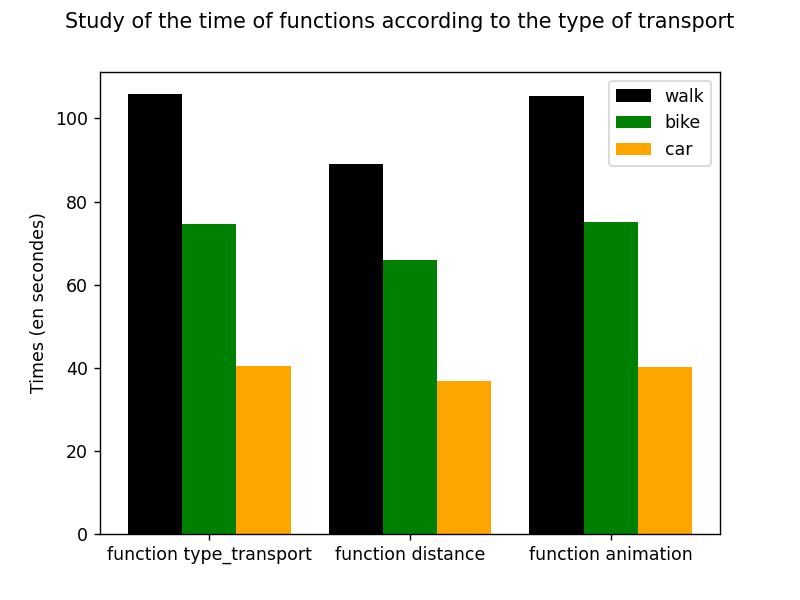

In [24]:
N = 3
ind = np.arange(N)
width = 0.27       # width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

yvals = [times_walk_type_transport, times_walk_distance, times_walk_animation]
rects1 = ax.bar(ind, yvals, width, color='black')
zvals = [times_bike_type_transport, times_bike_distance, times_bike_animation]
rects2 = ax.bar(ind+width, zvals, width, color='green')
kvals = [times_drive_type_transport,
         times_drive_distance, times_drive_animation]
rects3 = ax.bar(ind+width*2, kvals, width, color='orange')

ax.set_ylabel('Times (en secondes)')
ax.set_xticks(ind+width)
ax.set_xticklabels(
    ('function type_transport', 'function distance', 'function animation'))
ax.legend((rects1[0], rects2[0], rects3[0]), ('walk', 'bike', 'car'))
fig.suptitle(
    'Study of the time of functions according to the type of transport')
plt.savefig('histogram.pdf')

We can see that for all the functions combined, the type of transport taking the least time to compile is the car.

#### We do the same as time study for animation with matplotlib.

* By walk

In [25]:
times_walk_data = net.GeoJson_times('walk', net.geojson_data)
clear_output()

times_walk_GeoJson_animation = net.GeoJson_times(df_walk, net.geojson_visualization)
clear_output()

* By bike

In [26]:
times_bike_data = net.GeoJson_times('bike', net.geojson_data)
clear_output()

times_bike_GeoJson_animation = net.GeoJson_times(df_bike, net.geojson_visualization)
clear_output()

* By car

In [27]:
times_drive_data = net.GeoJson_times('drive', net.geojson_data)
clear_output()

times_drive_GeoJson_animation = net.GeoJson_times(df_drive, net.geojson_visualization)
clear_output()

Below, the time histogram according to the type of transport.

<IPython.core.display.Javascript object>


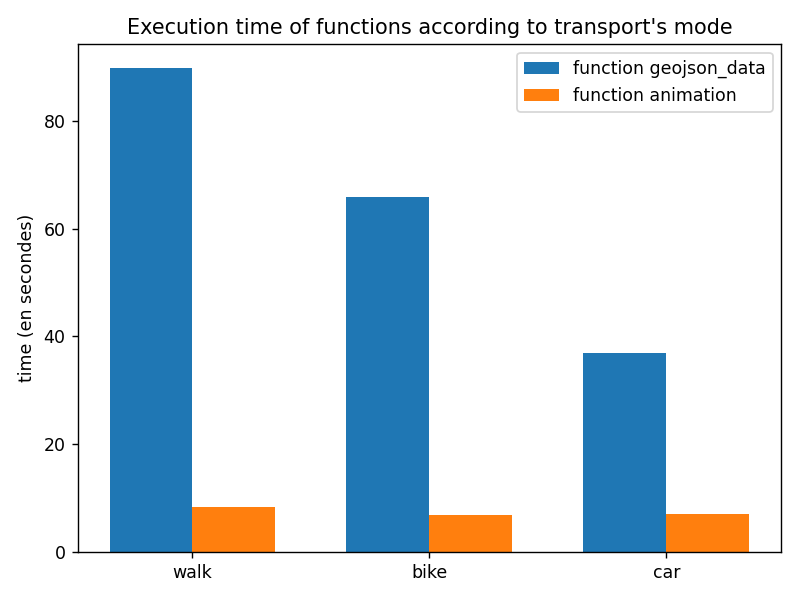

In [28]:
labels = ['walk', 'bike', 'car']
times_data = [times_walk_data, times_bike_data, times_drive_data]
times_animation = [times_walk_GeoJson_animation*50, times_bike_GeoJson_animation*50, times_drive_GeoJson_animation*50]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, times_data, width, label='function geojson_data')
rects2 = ax.bar(x + width/2, times_animation, width, label='function animation')

ax.set_ylabel('time (en secondes)')
ax.set_title('Execution time of functions according to transport\'s mode')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

Walk data function takes more of time to compile but animation functions have almost the same time of execution.

## Sparse matrix

In [29]:
print(net.sparse_matrix(5, 5))

  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0


# Animation by storing images on the fly:

In this section, we will expose the most interesting functions, these functions has for goal to create a folder names `temp`, and stores images into it, before using those images to create animation. A detailed report of this work can be found [here](https://github.com/asahbane/Report_animation/blob/master/project_network_notebook.ipynb). 

## Generating images :

The first function we will expose is `images_generate`, this function, will create a folder names temp, and stores images into it.

In [ ]:
net.images_generate('pedestrian')

In [ ]:
net.images_generate('car')

In [ ]:
net.images_generate('bike')

After running these lines, there must be a new folder that was created on the fly, in the main directory, inside that folder, images were stored.

## Animation :

The next function we will expose is `animate`, this function, will use the images ceated by the previous function to creat animation, simply by displaying them repeatedly one by one.

## Note 
This function can also be used to generate images, for that, we simply need to set the `create_images` parametre to __True__. By doing this, the function `images_generate` will be called inside the function `animate`.

In [ ]:
net.animate('pedestrian')

In [ ]:
net.make_map.animate('car')

In [ ]:
net.animate('bike')